# CARGANDO MODELOS Y DATOS


IMPORTAR MODELO RANDOM FOREST Y DATOS

In [2]:
!pip install huggingface_hub

In [4]:
import joblib
import requests
import pandas as pd
import io
from huggingface_hub import hf_hub_download
###OPTUNA
# URL directa al archivo .pkl
url1 = 'https://raw.githubusercontent.com/Mbenitez11/Prediccion-de-generacin-de-energia-solar-y-analisis-de-fallas/main/results/best_model.pkl'

# Descargar el archivo
response1 = requests.get(url1)

# Cargar el modelo desde el contenido descargado
best_model = joblib.load(io.BytesIO(response1.content))

###GRID SEARCH
# URL directa al archivo .pkl
url2 = 'https://raw.githubusercontent.com/Mbenitez11/Prediccion-de-generacin-de-energia-solar-y-analisis-de-fallas/main/results/best_model_grid.pkl'

# Descargar el archivo
response2 = requests.get(url2)

# Cargar el modelo desde el contenido descargado
best_model_grid = joblib.load(io.BytesIO(response2.content))


###RANDOM FOREST ENTRENADO

repo_id = "Mbrozon11/IRRADIATION_FORECASTING_RandomForest"
filename = "rfr.pkl"
rfr_path = hf_hub_download(repo_id=repo_id, filename=filename)

# Load the model
rfr = joblib.load(rfr_path)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


rfr.pkl:   0%|          | 0.00/3.01G [00:00<?, ?B/s]

In [5]:
# Cargar los datos

url_X_train='https://github.com/Mbenitez11/Prediccion-de-generacin-de-energia-solar-y-analisis-de-fallas/raw/refs/heads/main/results/X_train.pkl'
url_X_test='https://github.com/Mbenitez11/Prediccion-de-generacin-de-energia-solar-y-analisis-de-fallas/raw/refs/heads/main/results/X_test.pkl'
url_y_train='https://github.com/Mbenitez11/Prediccion-de-generacin-de-energia-solar-y-analisis-de-fallas/raw/refs/heads/main/results/y_train.pkl'
url_y_test='https://github.com/Mbenitez11/Prediccion-de-generacin-de-energia-solar-y-analisis-de-fallas/raw/refs/heads/main/results/y_test.pkl'
url_X1='https://github.com/Mbenitez11/Prediccion-de-generacin-de-energia-solar-y-analisis-de-fallas/raw/refs/heads/main/results/X1.pkl'
url_y1='https://github.com/Mbenitez11/Prediccion-de-generacin-de-energia-solar-y-analisis-de-fallas/raw/refs/heads/main/results/y1.pkl'

response1= requests.get(url_X_train)
response2=requests.get(url_X_test)
response3=requests.get(url_y_train)
response4=requests.get(url_y_test)
response5= requests.get(url_X1)
response6=requests.get(url_y1)

X_train = joblib.load(io.BytesIO(response1.content))
X_test = joblib.load(io.BytesIO(response2.content))
y_train = joblib.load(io.BytesIO(response3.content))
y_test = joblib.load(io.BytesIO(response4.content))
X1 = joblib.load(io.BytesIO(response5.content))
y1 = joblib.load(io.BytesIO(response6.content))

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
prediction_normal=rfr.predict(X_test)
prediction_optuna = best_model.predict(X_test)
prediction_grid = best_model_grid.predict(X_test)

In [9]:
cross_checking = pd.DataFrame({'Actual' : y_test['IRRADIATION'] , 'Predicted_normal' : prediction_normal, 'Predicted_optuna' : prediction_optuna, 'Predicted_grid' : prediction_grid})
cross_checking.iloc[1000:1005]

,Actual,Predicted_normal,Predicted_optuna,Predicted_grid
26793,0.000519,0.001574,0.009595,0.012682
193079,0.000304,0.001486,0.004239,0.005447
122040,0.045960,0.042884,0.071259,0.051586
317014,0.000433,0.008222,0.007960,0.005212
347138,0.000441,0.001979,0.007684,0.011189


In [10]:

# Crear una columna de error con las condiciones especificadas
cross_checking['Error_normal'] = np.where(
    (cross_checking['Actual'] == 0) & (cross_checking['Actual'] - cross_checking['Predicted_normal'] == 0),
    0,
    np.where(
        (cross_checking['Actual'] == 0) & (cross_checking['Actual'] - cross_checking['Predicted_normal'] != 0),
        np.nan, # Reemplaza "Probablemente Apagado" con np.nan
        abs(cross_checking['Actual'] - cross_checking['Predicted_normal']) * 100 / cross_checking['Actual']
    )
)

cross_checking['Error_optuna'] = np.where(
    (cross_checking['Actual'] == 0) & (cross_checking['Actual'] - cross_checking['Predicted_optuna'] == 0),
    0,
    np.where(
        (cross_checking['Actual'] == 0) & (cross_checking['Actual'] - cross_checking['Predicted_optuna'] != 0),
        np.nan, # Reemplaza "Probablemente Apagado" con np.nan
        abs(cross_checking['Actual'] - cross_checking['Predicted_optuna']) * 100 / cross_checking['Actual']
    )
)

cross_checking['Error_grid'] = np.where(
    (cross_checking['Actual'] == 0) & (cross_checking['Actual'] - cross_checking['Predicted_grid'] == 0),
    0,
    np.where(
        (cross_checking['Actual'] == 0) & (cross_checking['Actual'] - cross_checking['Predicted_grid'] != 0),
        np.nan, # Reemplaza "Probablemente Apagado" con np.nan
        abs(cross_checking['Actual'] - cross_checking['Predicted_grid']) * 100 / cross_checking['Actual']
    )
)


# Aplicar formato de estilo con un gradiente de color personalizado para resaltar errores altos en rojo
cross_checking.sample(25).style.background_gradient(
    cmap='coolwarm', subset=['Error_normal', 'Error_optuna', 'Error_grid']
).set_properties(**{
    'font-family': 'Lucida Calligraphy',
    'color': 'DarkBlack',
    'font-size': '15px'
})

,Actual,Predicted_normal,Predicted_optuna,Predicted_grid,Error_normal,Error_optuna,Error_grid
191658,0.000461,0.001071,0.009230,0.012634,132.249458,1902.264151,2640.491596
430653,0.015010,0.018457,0.012826,0.021669,22.964890,14.549369,44.363878
411895,0.099900,0.191814,0.213835,0.221917,92.006306,114.049519,122.139598
110697,0.182200,0.112595,0.115637,0.130031,38.202305,36.532852,28.633001
236316,0.147500,0.174605,0.194006,0.155052,18.376271,31.529654,5.119856
180366,0.025000,0.053132,0.050789,0.058620,112.530000,103.156741,134.480924
226674,0.407500,0.407531,0.370086,0.349343,0.007607,9.181459,14.271724
176938,0.000454,0.001792,0.001599,0.001284,294.645374,252.123151,182.778121
322606,0.000406,0.032487,0.005813,0.007645,7901.756158,1331.770493,1783.007736
197475,0.013590,0.001455,0.003462,0.005212,89.296174,74.528620,61.648324


In [11]:
X_test.head()

,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,WIND_SPEED,SEASON
333998,21.420,27.330,0.5,1
23070,-7.025,-6.160,2.0,2
28538,6.870,4.165,8.0,2
266661,23.700,19.730,0.4,4
1283,7.937,7.928,1.2,2


In [13]:
cross_checking['MODULE_TEMPERATURE']=X_test['MODULE_TEMPERATURE']
cross_checking['AMBIENT_TEMPERATURE']=X_test['AMBIENT_TEMPERATURE']


In [15]:
cross_checking[['Actual','MODULE_TEMPERATURE','AMBIENT_TEMPERATURE','Error_normal', 'Error_optuna', 'Error_grid']].sample(25).style.background_gradient(
    cmap='coolwarm', subset=['Error_normal', 'Error_optuna', 'Error_grid']
).set_properties(**{
    'font-family': 'Lucida Calligraphy',
    'color': 'DarkBlack',
    'font-size': '15px'
})

,Actual,MODULE_TEMPERATURE,AMBIENT_TEMPERATURE,Error_normal,Error_optuna,Error_grid
234411,0.000463,21.000000,22.040000,24.740821,1067.711140,889.915813
297828,0.000924,15.580000,19.810000,37.909091,182.277899,453.301634
433015,0.547500,20.500000,-0.260000,0.671233,7.642281,12.679240
354645,0.000489,13.900000,18.350000,23.832311,379.147289,568.184853
117405,0.040690,-0.642000,5.166000,98.182969,81.116197,72.502740
69943,0.000440,12.700000,13.610000,13.975000,1681.518371,2055.462735
328261,0.000425,9.640000,14.810000,195.632941,1437.758863,1646.092851
377916,0.414500,23.080000,5.503000,6.770084,5.204749,3.755529
407828,0.000305,6.146000,11.000000,8.885246,4138.235919,6001.745858
362724,0.000508,16.080000,19.720000,79.314961,361.226426,543.193687


# **GRAFICAS**

Grafico de Dispersion

<ipython-input-16-0c1938f5fa63>:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([cross_checking['Actual'].min(), cross_checking['Actual'].max()],


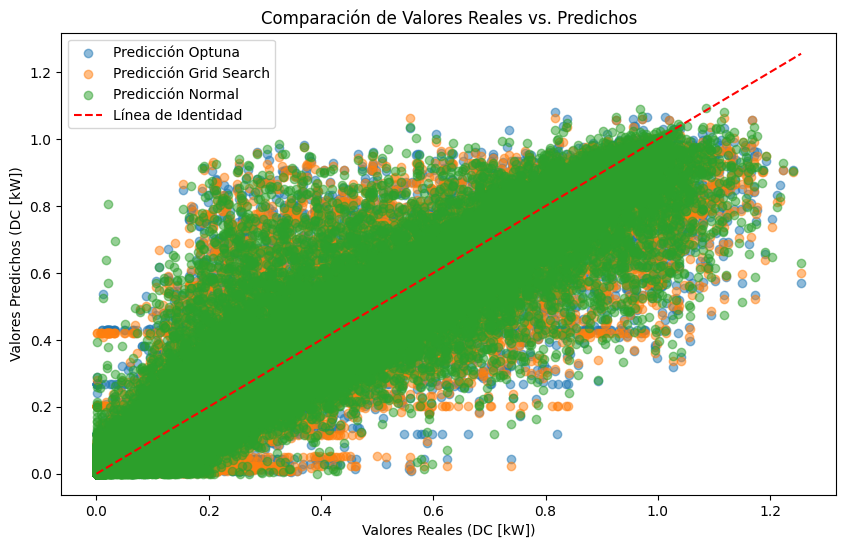

In [16]:

plt.figure(figsize=(10, 6))

plt.scatter(cross_checking['Actual'], cross_checking['Predicted_optuna'], alpha=0.5, label='Predicción Optuna')
plt.scatter(cross_checking['Actual'], cross_checking['Predicted_grid'], alpha=0.5, label='Predicción Grid Search')
plt.scatter(cross_checking['Actual'], cross_checking['Predicted_normal'], alpha=0.5, label='Predicción Normal')
plt.plot([cross_checking['Actual'].min(), cross_checking['Actual'].max()],
         [cross_checking['Actual'].min(), cross_checking['Actual'].max()],
         'k--', color='red', label='Línea de Identidad')
plt.xlabel('Valores Reales (DC [kW])')
plt.ylabel('Valores Predichos (DC [kW])')
plt.legend()
plt.title('Comparación de Valores Reales vs. Predichos')
plt.show()


Histograma de errores

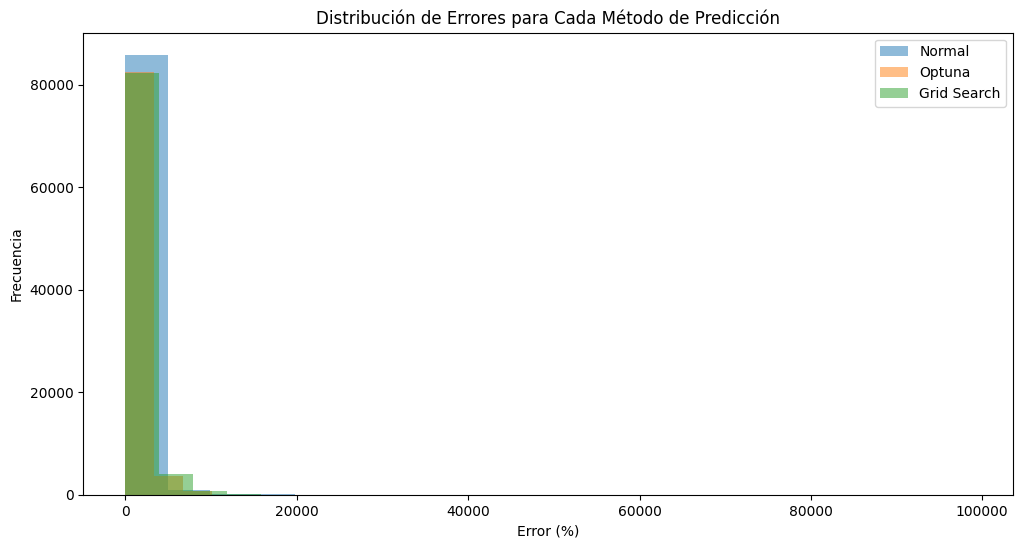

In [17]:
plt.figure(figsize=(12, 6))
plt.hist(cross_checking['Error_normal'], bins=20, alpha=0.5, label='Normal')
plt.hist(cross_checking['Error_optuna'], bins=20, alpha=0.5, label='Optuna')
plt.hist(cross_checking['Error_grid'], bins=20, alpha=0.5, label='Grid Search')


plt.xlabel('Error (%)')
plt.ylabel('Frecuencia')
plt.title('Distribución de Errores para Cada Método de Predicción')
plt.legend()
plt.show()


Gráfico de Barras Comparativo

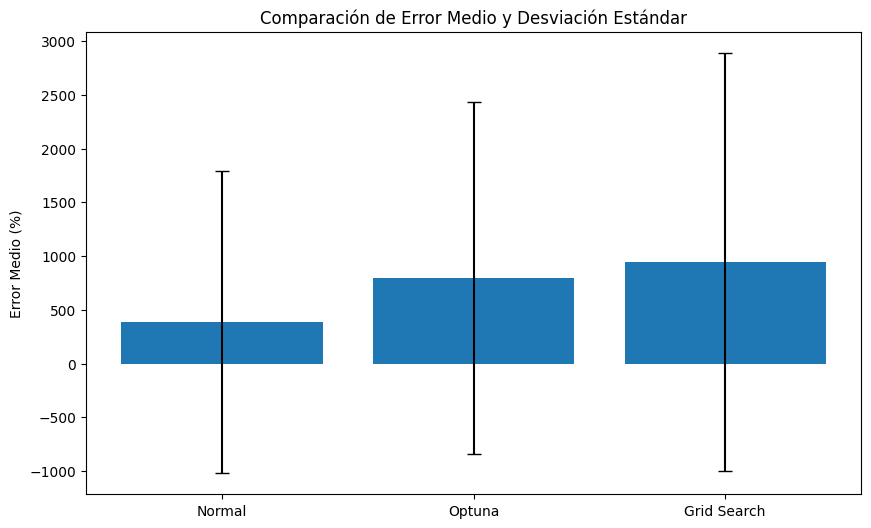

In [18]:

# Calcular la media y desviación estándar de los errores
mean_errors = [cross_checking['Error_normal'].mean(), cross_checking['Error_optuna'].mean(), cross_checking['Error_grid'].mean()]
std_errors = [cross_checking['Error_normal'].std(), cross_checking['Error_optuna'].std(), cross_checking['Error_grid'].std()]

# Crear el gráfico de barras con barras de error
plt.figure(figsize=(10, 6))
plt.bar(['Normal', 'Optuna', 'Grid Search'], mean_errors, yerr=std_errors, capsize=5)
plt.ylabel('Error Medio (%)')
plt.title('Comparación de Error Medio y Desviación Estándar')
plt.show()


Violin Plot

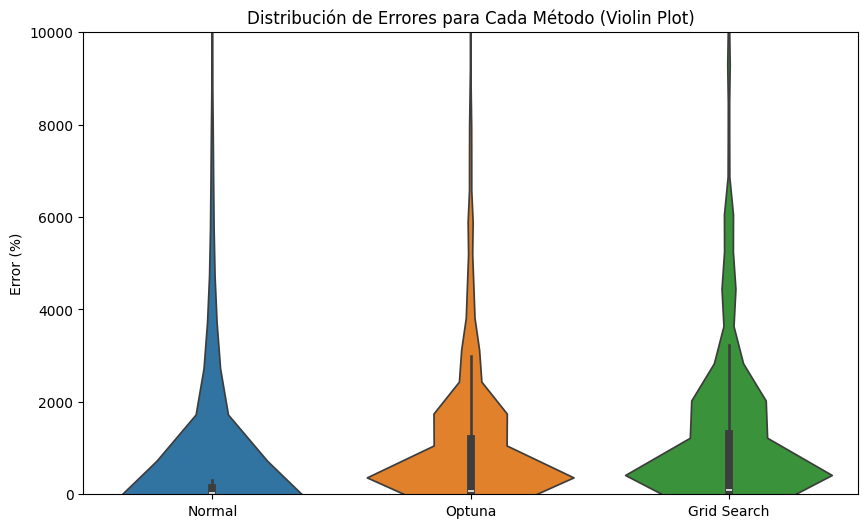

In [23]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.violinplot(data=[cross_checking['Error_normal'], cross_checking['Error_optuna'], cross_checking['Error_grid']])
plt.xticks([0, 1, 2], ['Normal', 'Optuna', 'Grid Search'])
plt.ylim(0, 10000)
plt.ylabel('Error (%)')
plt.title('Distribución de Errores para Cada Método (Violin Plot)')
plt.show()


Gráfico KDE

<ipython-input-22-aec1aed6d525>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(cross_checking['Error_normal'], label='Normal', shade=True)
<ipython-input-22-aec1aed6d525>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(cross_checking['Error_optuna'], label='Optuna', shade=True)
<ipython-input-22-aec1aed6d525>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(cross_checking['Error_grid'], label='Grid Search', shade=True)


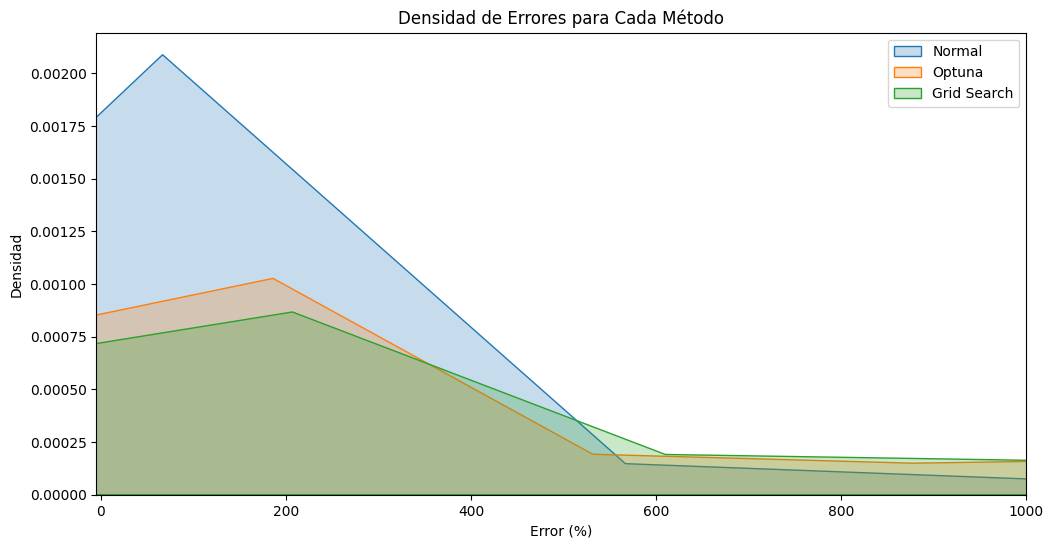

In [22]:
plt.figure(figsize=(12, 6))
sns.kdeplot(cross_checking['Error_normal'], label='Normal', shade=True)
sns.kdeplot(cross_checking['Error_optuna'], label='Optuna', shade=True)
sns.kdeplot(cross_checking['Error_grid'], label='Grid Search', shade=True)
plt.xlim(-5, 1000)
plt.xlabel('Error (%)')
plt.ylabel('Densidad')
plt.title('Densidad de Errores para Cada Método')
plt.legend()
plt.show()


Grafico CDF

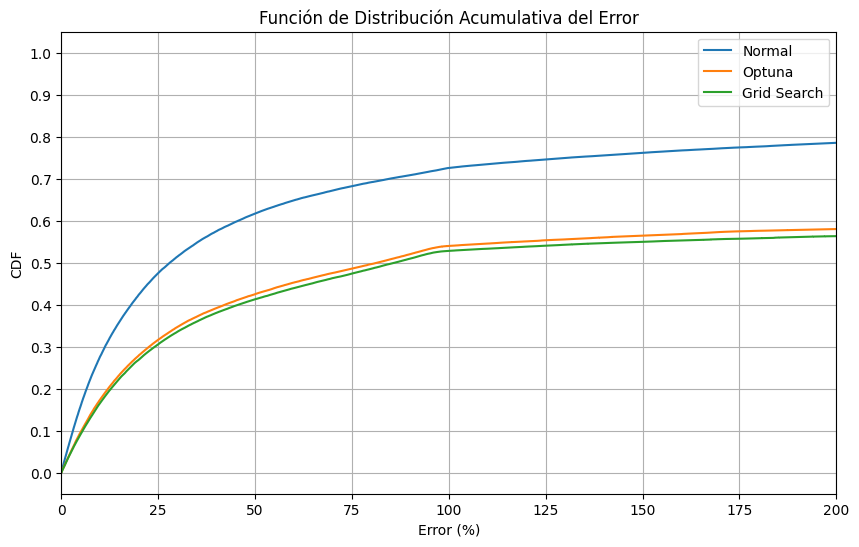

In [26]:


plt.figure(figsize=(10, 6))
for errors, label in zip([cross_checking['Error_normal'], cross_checking['Error_optuna'], cross_checking['Error_grid']],
                         ['Normal', 'Optuna', 'Grid Search']):
    sorted_errors = np.sort(errors)
    yvals = np.arange(len(sorted_errors)) / float(len(sorted_errors))
    plt.plot(sorted_errors, yvals, label=label)
plt.xlim(0, 200)
plt.xlabel('Error (%)')
plt.ylabel('CDF')
plt.title('Función de Distribución Acumulativa del Error')
plt.legend()


plt.yticks(np.arange(0, 1.1, 0.1))  # Cambia el rango y los intervalos del eje y
plt.grid(True)
plt.show()


# APLICACIONES

 1. Optimización de la operación de plantas solares:
    - Predecir la generación de energía con antelación, permitiendo una mejor gestión de la producción y distribución de energía.
   - Identificar patrones de generación y anticipar posibles fluctuaciones, optimizando el uso de recursos y evitando pérdidas.
 2. Toma de decisiones estratégicas en la inversión en energía solar:
   - Evaluar la rentabilidad de proyectos de energía solar en diferentes ubicaciones y condiciones climáticas.
    -  Aportar información crucial para inversores y desarrolladores de proyectos, minimizando riesgos y maximizando retornos.

 3.  Monitoreo y mantenimiento predictivo:
    -  Detectar anomalías en la generación de energía que podrían indicar fallas o problemas técnicos.
    -  Permitir una intervención temprana para evitar interrupciones en la producción y minimizar costos de mantenimiento.

 4. Integración con sistemas de gestión de energía:
    -  Integrar el modelo en sistemas de gestión de energía más amplios para optimizar la gestión del consumo y la generación.
    -  Facilitar la integración de la energía solar con otras fuentes de energía, mejorando la eficiencia del sistema.

 5. Análisis del impacto de variables climáticas:
    - Analizar la influencia de variables climáticas como la radiación solar, la temperatura ambiente y la temperatura del módulo en la generación de energía.
    -  Mejorar la precisión de las predicciones y adaptar las estrategias de gestión a las condiciones climáticas específicas.

 6.  Planificación de la expansión de la infraestructura solar:#    - Informar decisiones sobre la expansión de la infraestructura de generación de energía solar, considerando las predicciones de generación y las necesidades de consumo.
    -  Optimizar la ubicación y el tamaño de nuevas plantas solares para maximizar su impacto.

 7.  Estudios de impacto ambiental:
    - Evaluar el impacto ambiental de la energía solar y contribuir al desarrollo de proyectos sostenibles.
   -  Contribuir al desarrollo de modelos de gestión de energía más responsables con el medio ambiente.

 Ejemplo de uso:

 Predecir la generación de energía para las siguientes 24 horas utilizando los datos climáticos disponibles.
 Los datos deben incluir radiación solar, temperatura del módulo, y temperatura ambiente.

In [27]:
solar_data = pd.read_csv('https://raw.githubusercontent.com/Mbenitez11/Prediccion-de-generacin-de-energia-solar-y-analisis-de-fallas/refs/heads/main/data/SolarPrediction.csv')

In [28]:
solar_data.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [29]:
solar_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 2.7+ MB


In [30]:
solar_data['Data'] = pd.to_datetime(solar_data['Data'], format='%m/%d/%Y %I:%M:%S %p')

In [31]:
solar_data.isnull().sum()

,0
UNIXTime,0
Data,0
Time,0
Radiation,0
Temperature,0
Pressure,0
Humidity,0
WindDirection(Degrees),0
Speed,0
TimeSunRise,0


In [32]:
X_train.head()


,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,WIND_SPEED,SEASON
189849,30.890,32.400,1.4,4
303125,20.900,16.150,1.6,1
90280,5.550,21.820,10.1,3
45688,3.481,6.894,2.4,2
430217,4.109,6.209,1.0,2


In [33]:
import random
df_solar = pd.DataFrame({'DATE_TIME' : solar_data['Data'], 'AMBIENT_TEMPERATURE' : solar_data['Temperature'], 'MODULE_TEMPERATURE' : solar_data['Temperature'],'WIND_SPEED' : solar_data['Speed'], 'SEASON' : 4})

In [34]:
df_solar.head()

,DATE_TIME,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,WIND_SPEED,SEASON
0,2016-09-29,48,48,5.62,4
1,2016-09-29,48,48,3.37,4
2,2016-09-29,48,48,3.37,4
3,2016-09-29,48,48,3.37,4
4,2016-09-29,48,48,5.62,4


In [35]:
prediction=rfr.predict(df_solar[['AMBIENT_TEMPERATURE',	'MODULE_TEMPERATURE','WIND_SPEED',	'SEASON']])

In [36]:
prediction

array([0.361104, 0.347072, 0.347072, ..., 0.321659, 0.321659, 0.241682])

In [37]:
df_solar['IRRADIATION']=prediction

In [38]:
df_solar.iloc[1000:1010]

,DATE_TIME,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,WIND_SPEED,SEASON,IRRADIATION
1000,2016-09-26,57,57,10.12,4,0.504343
1001,2016-09-26,57,57,4.50,4,0.469796
1002,2016-09-26,58,58,10.12,4,0.503785
1003,2016-09-26,58,58,9.00,4,0.503785
1004,2016-09-26,57,57,9.00,4,0.504343
1005,2016-09-26,57,57,7.87,4,0.504343
1006,2016-09-26,57,57,7.87,4,0.504343
1007,2016-09-26,57,57,7.87,4,0.504343
1008,2016-09-26,56,56,3.37,4,0.507294
1009,2016-09-26,56,56,4.50,4,0.560910


In [39]:
df_solar["DATE"] = pd.to_datetime(df_solar["DATE_TIME"]).dt.date
df_solar["TIME"] = pd.to_datetime(df_solar["DATE_TIME"]).dt.time
df_solar['DAY'] = pd.to_datetime(df_solar['DATE_TIME']).dt.day
df_solar['MONTH'] = pd.to_datetime(df_solar['DATE_TIME']).dt.month
df_solar['WEEK'] = pd.to_datetime(df_solar['DATE_TIME']).dt.isocalendar().week # Use isocalendar().week instead of week

# add hours and minutes for ml models
df_solar['HOURS'] = pd.to_datetime(df_solar['TIME'],format='%H:%M:%S').dt.hour
df_solar['MINUTES'] = pd.to_datetime(df_solar['TIME'],format='%H:%M:%S').dt.minute
df_solar['TOTAL MINUTES PASS'] = df_solar['MINUTES'] + df_solar['HOURS']*60

# add date as string column
df_solar["DATE_STRING"] = df_solar["DATE"].astype(str) # add column with date as string
df_solar["HOURS"] = df_solar["HOURS"].astype(str)
df_solar["TIME"] = df_solar["TIME"].astype(str)

df_solar.iloc[1000:1010]

,DATE_TIME,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,WIND_SPEED,SEASON,IRRADIATION,DATE,TIME,DAY,MONTH,WEEK,HOURS,MINUTES,TOTAL MINUTES PASS,DATE_STRING
1000,2016-09-26,57,57,10.12,4,0.504343,2016-09-26,00:00:00,26,9,39,0,0,0,2016-09-26
1001,2016-09-26,57,57,4.50,4,0.469796,2016-09-26,00:00:00,26,9,39,0,0,0,2016-09-26
1002,2016-09-26,58,58,10.12,4,0.503785,2016-09-26,00:00:00,26,9,39,0,0,0,2016-09-26
1003,2016-09-26,58,58,9.00,4,0.503785,2016-09-26,00:00:00,26,9,39,0,0,0,2016-09-26
1004,2016-09-26,57,57,9.00,4,0.504343,2016-09-26,00:00:00,26,9,39,0,0,0,2016-09-26
1005,2016-09-26,57,57,7.87,4,0.504343,2016-09-26,00:00:00,26,9,39,0,0,0,2016-09-26
1006,2016-09-26,57,57,7.87,4,0.504343,2016-09-26,00:00:00,26,9,39,0,0,0,2016-09-26
1007,2016-09-26,57,57,7.87,4,0.504343,2016-09-26,00:00:00,26,9,39,0,0,0,2016-09-26
1008,2016-09-26,56,56,3.37,4,0.507294,2016-09-26,00:00:00,26,9,39,0,0,0,2016-09-26
1009,2016-09-26,56,56,4.50,4,0.560910,2016-09-26,00:00:00,26,9,39,0,0,0,2016-09-26


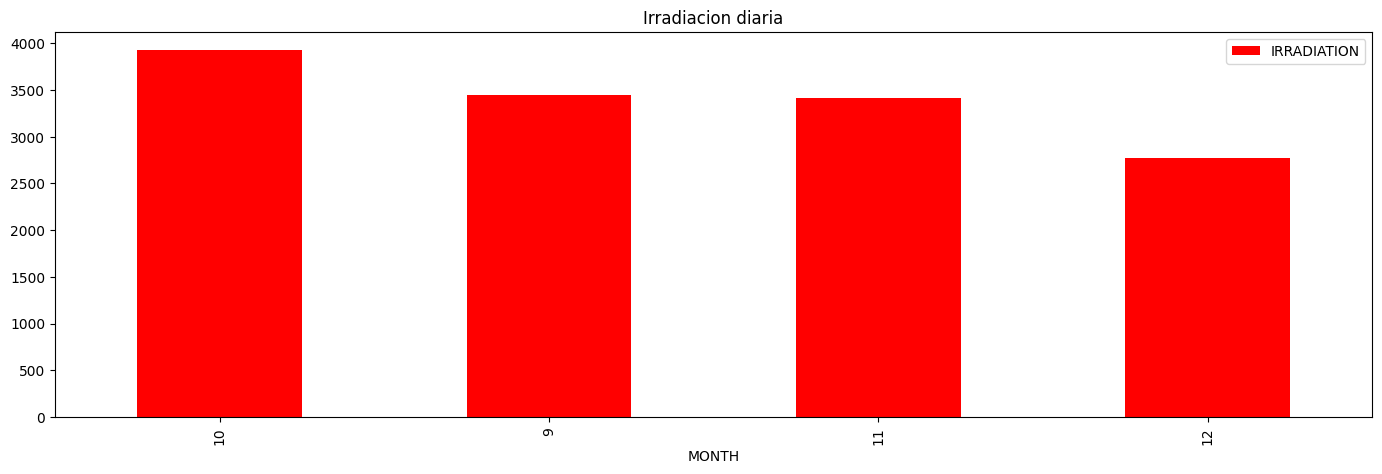

In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")


daily_dc = df_solar.groupby('MONTH')['IRRADIATION'].agg('sum')

ax = daily_dc.sort_values(ascending=False).plot.bar(figsize=(17,5), legend=True,color='red')
plt.title('Irradiacion diaria')
plt.show()

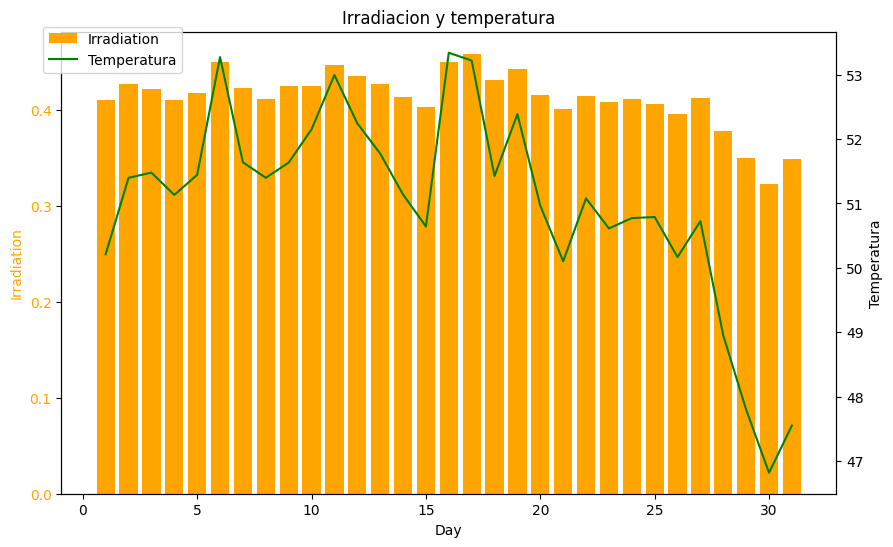

In [41]:

# Filtrar datos y crear el día de cada fecha
df_solar['Day'] = df_solar['DATE_TIME'].dt.day
irradiation = df_solar.groupby('Day')['IRRADIATION'].mean()
temperature= df_solar.groupby('Day')['AMBIENT_TEMPERATURE'].mean()
# Crear gráfico
fig, ax1 = plt.subplots(figsize=(10, 6))

# Gráfico de Irradiation
ax1.bar(irradiation.index, irradiation.values, color='orange', label='Irradiation')
ax1.set_xlabel('Day')
ax1.set_ylabel('Irradiation', color='orange')
ax1.tick_params(axis='y', labelcolor='orange')

# Crear segundo eje y graficar DC y AC Power
ax2 = ax1.twinx()
ax2.plot(temperature.index, temperature.values, color='green', label='Temperatura')
ax2.set_ylabel('Temperatura', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Agregar leyenda
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))
plt.title('Irradiacion y temperatura')
plt.show()

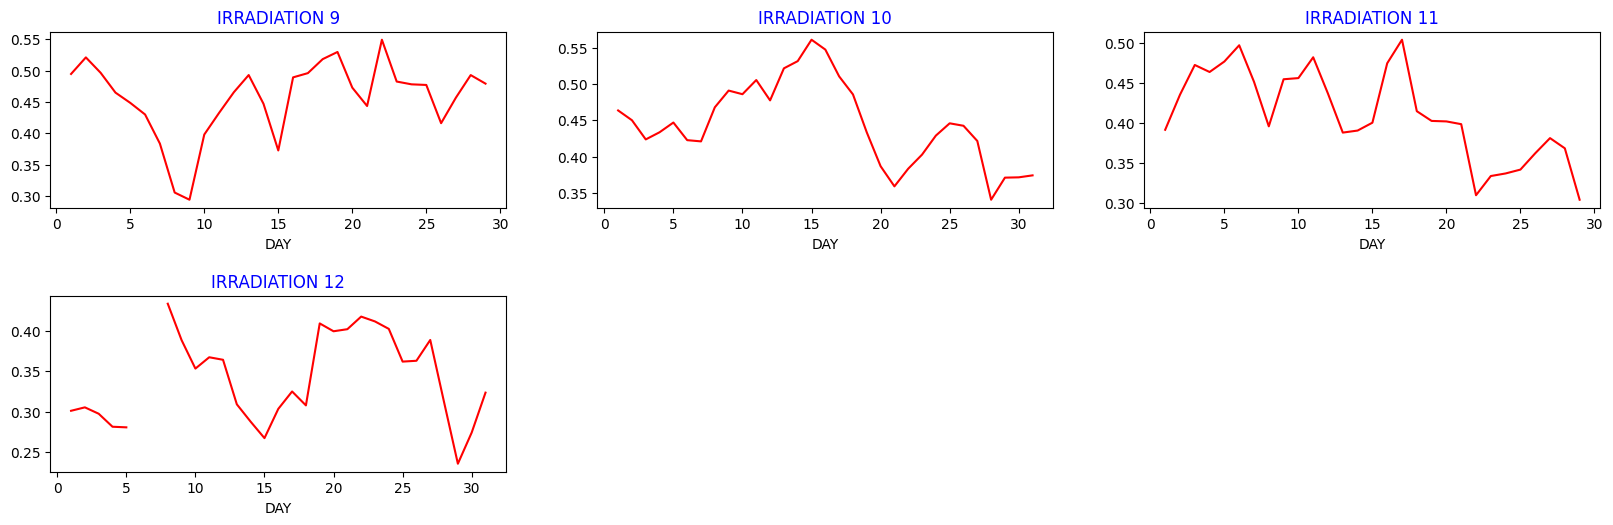

In [42]:
solar_dc = df_solar.pivot_table(values='IRRADIATION', index='DAY', columns='MONTH')

def Daywise_plot(data= None, row = None, col = None, title='IRRADIATION'):
    cols = data.columns # take all column
    gp = plt.figure(figsize=(20,40))

    gp.subplots_adjust(wspace=0.2, hspace=0.5)
    for i in range(1, len(cols)+1):
        ax = gp.add_subplot(row,col, i)
        data[cols[i-1]].plot(ax=ax, color='red')
        ax.set_title('{} {}'.format(title, cols[i-1]),color='blue')

Daywise_plot(data=solar_dc, row=12, col=3)

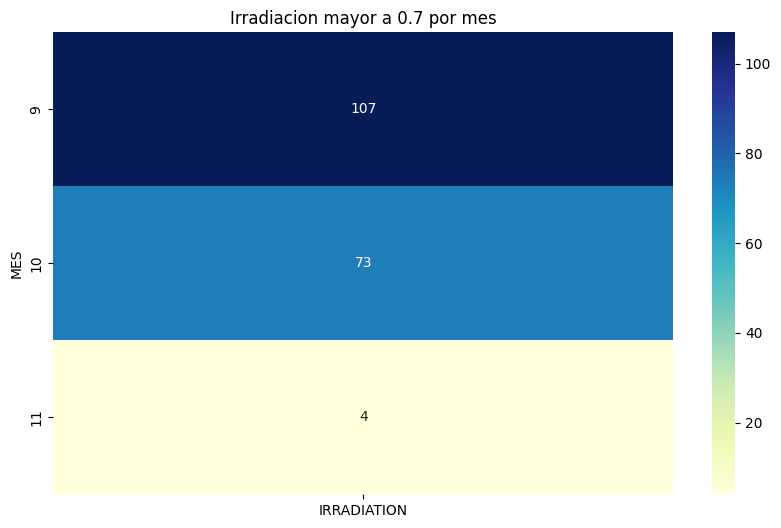

In [47]:
irradiacion_frecuencia=df_solar[df_solar['IRRADIATION'] > 0.7].groupby(df_solar['DATE_TIME' ].dt.month) [['IRRADIATION' ]].count()

plt.figure(figsize=(10, 6))
sns.heatmap(irradiacion_frecuencia, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Irradiacion mayor a 0.7 por mes')
plt.ylabel('MES')
plt.show()

CONSIDERANDO UN TRANSFORMADOR MODELO [HiKu6 Mono PERC 530 W ~ 555 W CS6W-530MS](https://static.csisolar.com/wp-content/uploads/2020/06/21135332/CS-Datasheet-HiKu6_CS6W-MS_v2.1_EN.pdf) que tiene un Isc=11.13 A




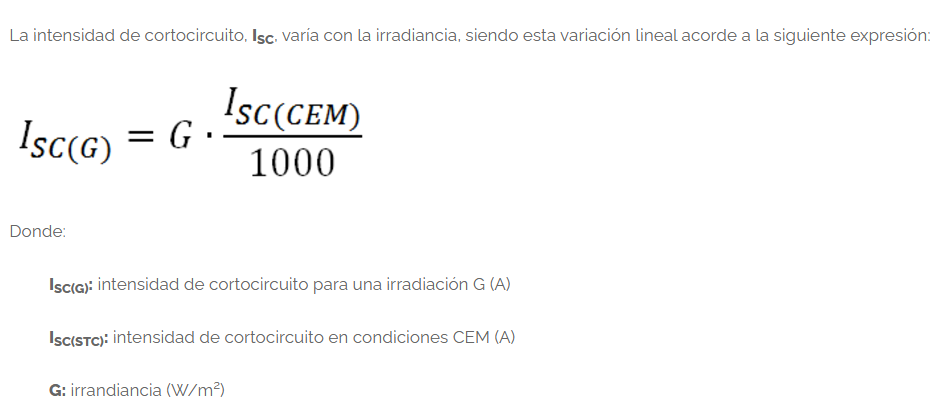



La corriente generada será:

In [43]:
df_solar['CURRENT']=df_solar['IRRADIATION']*11.13